In [58]:
import os
from modules.models import *
from modules.arg_utils import int_or_int_list_or_none
from util import get_prompt_template
from PIL import Image
import torchaudio
from torchvision import transforms as vt
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:1' if USE_CUDA else 'cpu')
save_path = 'checkpoints'
model_name = 'ACL_ViT16'
exp_name = '0'

model_exp_name = f'{model_name}_{exp_name}' if exp_name != "" else model_name

In [3]:
model_conf_file = f'./config/model/{model_name}.yaml'
model = ACL(model_conf_file, device)
model.train(False)


In [4]:
# Load model
postfix = 'best'
model_dir = os.path.join(save_path, model_exp_name, f'Param_{postfix}.pth')
model.load(model_dir) 

In [9]:
prompt_template, text_pos_at_prompt, prompt_length = get_prompt_template()

In [76]:
def draw_overlaid(original_image: Image.Image, heatmap_image: Image.Image) -> None:
    '''
    Draw an overlaid figure with the original image and heatmap.

    Args:
        result_dir (str): Directory to save the figure.
        original_image (Image.Image): Original image.
        heatmap_image (Image.Image): Heatmap image.
        name (str): Name identifier.

    Returns:
        None
    '''
    heatmap_image = cv2.applyColorMap(np.array(heatmap_image), cv2.COLORMAP_JET)
    overlaid_image = cv2.addWeighted(np.array(original_image), 0.5, heatmap_image, 0.5, 0)
    overlaid_image = Image.fromarray(overlaid_image)
    
    return overlaid_image

In [28]:
def get_audio(wav_path):
    SAMPLE_RATE = 16000
    set_length = 10
    
    audio_file, _ = torchaudio.load(wav_path)
    audio_file = audio_file.squeeze(0)
    
    if audio_file.shape[0] > (SAMPLE_RATE * set_length):
        audio_file = audio_file[:SAMPLE_RATE * set_length]
        
    if audio_file.shape[0] < (SAMPLE_RATE * set_length):
        pad_len = (SAMPLE_RATE * set_length) - audio_file.shape[0]
        pad_val = torch.zeros(pad_len)
        audio_file = torch.cat((audio_file, pad_val), dim=0)

    return audio_file

def get_image(img_path):
    image_file = Image.open(img_path)
    return image_file

input_resolution = 224
image_transform = vt.Compose([
    vt.Resize((input_resolution, input_resolution), vt.InterpolationMode.BICUBIC),
    vt.ToTensor(),
    vt.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),  # CLIP
])

In [103]:
audios =[]
audio = get_audio('accordion_baby_10467_baby.wav')
audio = audio.unsqueeze(0)
audios.append(audio)
audio = get_audio('accordion_baby_10467_accordion.wav')
audio = audio.unsqueeze(0)
audios.append(audio)
audios = torch.vstack(audios)
images = get_image('accordion_baby_10467_accordion.jpg')
images = image_transform(images)
images = images.unsqueeze(0)

In [105]:
placeholder_tokens = model.get_placeholder_token(prompt_template.replace('{}', ''))
placeholder_tokens = placeholder_tokens.repeat((audios.shape[0], 1))
audio_driven_embedding = model.encode_audio(audios.to(model.device), placeholder_tokens, text_pos_at_prompt,
                                            prompt_length)
out_dict = model(images.to(model.device), audio_driven_embedding, 224)

In [130]:
overlaid_images = []
original_image = Image.open(os.path.join('accordion_baby_10467_accordion.jpg')).resize((224, 224))
overlaid_images.append(original_image)

for i in range(audios.shape[0]):
    img_uint8 = out_dict['heatmap'][i][0].cpu().detach()
    img_uint8 = 255-img_uint8*255
    img_uint8 = img_uint8.type(torch.uint8).numpy()
    heatmap_image = Image.fromarray(img_uint8)

    overlaid_image = draw_overlaid(original_image, heatmap_image)
    overlaid_images.append(overlaid_image)
names = ['Original Image','Audio1','Audio2']

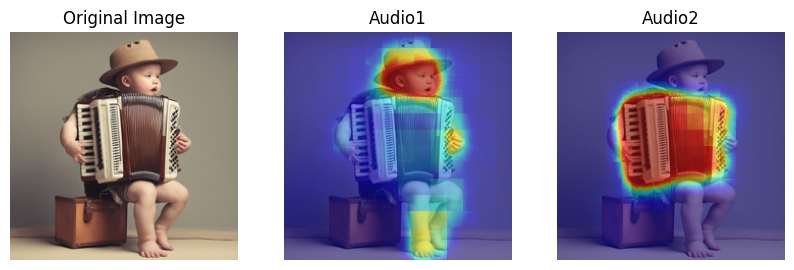

In [132]:
plt.figure(figsize=(10,30))
for i in range(len(overlaid_images)):
    plt.subplot(1,3,i+1)
    plt.imshow(overlaid_images[i])
    plt.title(names[i])
    plt.axis('off')